# ECE-5424 / CS-5824 Advanced Machine Learning
# Project: SampleCNN


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

#%cd /content/gdrive/MyDrive/ECE 5424 ML/homework_spring/Project/Data/audio_to_npy
#pwd 
#!cp -r '/content/gdrive/MyDrive/ECE 5424 ML/homework_spring/Project/Data/audio_to_npy' '/content/gdrive/My Drive/ECE 5424 ML/homework_spring/Project/Data/wav_to_npy_2'

Mounted at /content/gdrive/


In [ ]:
import sys
import os
prefix = '/content/gdrive/My Drive/'
customized_path = 'ECE 5424 ML/homework_spring/Project'
sys_path = os.path.join(prefix, customized_path)
sys.path.append(sys_path)

#import tarfile
#tar = tarfile.open('/content/gdrive/My Drive/ECE 5424 ML/homework_spring/Project/TJC/data/scd/raw/speech_commands_v0.02.tar.gz', "r:gz")
#    tar.extractall()
#    tar.close()

#cwd = os.getcwd()
#os.chdir(r'/content/gdrive/My Drive/ECE 5424 ML/homework_spring/Project/TJC/data/scd/raw') 

#try:
#  new_path = sys_path
#  new_path = os.path.join(new_path,"Data")
#  os.mkdir(new_path)
#  new_path = os.path.join(new_path,"train")
#  os.mkdir(new_path)
#  new_path = os.path.join(new_path,"train")
#  os.mkdir(new_path)
#  new_path = os.path.join(new_path,"audio")
#  os.mkdir(new_path)
  
#  new_path = sys_path
#  new_path = os.path.join(new_path,"Data")
#  new_path = os.path.join(new_path,"sampleCNN-data")
#  os.mkdir(new_path)

#except:
#  pass

### Path and Libraries

In [ ]:
# Comment out after first run
!pip install librosa
!pip install soundfile

In [ ]:
import numpy as np
import pandas as pd
import sklearn as sk
import torch 
import torch.nn as nn
import librosa
import errno
import soundfile
from torch.optim import lr_scheduler
import warnings
from pathlib import Path

In [ ]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print(torch.cuda.get_device_name())

# Audio Processing

### Setting Directories

In [ ]:
DATA_DIR = sys_path + '/Data/'
ANNOT_FILE = sys_path + '/Data/annotations_final_command3.csv'
MTT_DIR = sys_path + '/Data/train/train/audio/' # wav main folder dir 

AUDIO_DIR = sys_path + '/Data/audio_to_npy/' # folder for audio files converted to numpy arrays
BASE_DIR = sys_path + '/Data/sampleCNN-data/' # data dir for this model 
LIST_OF_TAGS = sys_path + '/Data/sampleCNN-data/12_tags.txt'

# Audio Configuration

In [ ]:
DEVICE_IDS=[0,1]

# audio params 
SR = 22050
NUM_SAMPLES = 22050
NUM_TAGS = 12

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: Numeric-style type codes are deprecated and will result in an error in the future.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


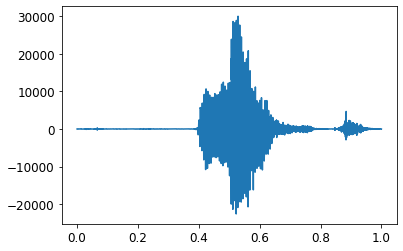

In [ ]:
## Visualizing Waveforms
npyfile = AUDIO_DIR + 'cat/6c9223bd_nohash_0.npy'
npyfile = AUDIO_DIR + 'cat/ffd2ba2f_nohash_0.npy'
npyfile = AUDIO_DIR + 'left/e53139ad_nohash_0.npy'
npyfile = AUDIO_DIR + 'left/f0ae7203_nohash_0.npy'
song = np.load(npyfile)

import matplotlib.pyplot as plt
import numpy as np
import wave
import sys

ap = MTT_DIR + 'left/f0ae7203_nohash_0.wav'

spf = wave.open(ap, "r")

# Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, "Int16")
fs = spf.getframerate()

# If Stereo
if spf.getnchannels() == 2:
    print("Just mono files")
    sys.exit(0)


Time = np.linspace(0, len(signal) / fs, num=len(signal))

plt.figure(1)
#plt.title("Signal Wave...")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot(Time, signal)
plt.show()

# Audio Importing and Conversion

In [ ]:
# Defining a function that loads, audio files, converts them to numpy arrays, then saves them on the drive
def save_audio_to_npy(rawfilepath, npyfilepath):
    ''' Save audio signal with sr=sample_rate to npy file 
    Args : 
        rawfilepath : path to the mp3 audio files 
        npyfilepath : path to save the numpy array audio signal 
    Return :
        None 
    '''
    #rawfilepath = MTT_DIR
    # Retrieves list of subfolders from main mp3 folder
    mydir = [path for path in os.listdir(rawfilepath)]
    print(mydir)
    for path in mydir: 
        # create directory with names matching subfolders in mp3 folder
        try:
            os.mkdir(Path(npyfilepath) / path)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
        # Retrieves list of all mp3 files within the specified subfolder
        audios = [audio for audio in os.listdir(Path(rawfilepath) / path) if audio.split(".")[-1] == 'wav']
        # Loop through all mp3 files
        for audio in audios :
            try:
                #print(os.path.join(rawfilepath,path,audio))
                # suppress warnings
                warnings.filterwarnings("ignore")
                with warnings.catch_warnings():
                  warnings.simplefilter("ignore")
                # read audio file and save as numpy array
                y,sr = librosa.load(os.path.join(rawfilepath,path,audio), sr=SR)
                print(y)
                #if len(y)/NUM_SAMPLES < 10:
                  #print("There are less than 10 segments in this audio")
            except:
                print("Cannot load audio {}".format(audio))
                pass

            fn = audio.split(".")[0]
            # Save resulting files to folder
            np.save(Path(npyfilepath) / (path + '/' + fn + '.npy'), y)


def get_segment_from_npy(npyfile, segment_idx, NUM_SAMPLES, MTT_DIR, AUDIO_DIR):
    ''' Return random segment of length num_samples from the audio 
    Args : 
        npyfile : path to all the npy files each containing audio signals 
        segment_idx : index of the segment to retrieve; max(segment_idx) = total_samples//num_samples
    Return : 
        segment : audio signal of length num_samples 
    '''
    #npyfile = audio_dir + mp3filename
    song = np.load(npyfile)
    # randidx = np.random.randint(10)
    try : 
        segment = song[segment_idx * NUM_SAMPLES : (segment_idx+1)*NUM_SAMPLES]
    except : 
        randidx = np.random.randint(10)
        get_segment_from_npy(npyfile, randidx, NUM_SAMPLES, MTT_DIR, AUDIO_DIR)
    return segment

In [ ]:
############ WARNING: Only run this once, it takes about 8 hours to complete and save the files to the directory ###############
################################################################################################################################
#save_audio_to_npy(MTT_DIR, AUDIO_DIR)

# Annotation Processing

In [ ]:
# setting seed
np.random.seed(0)

def split_data(filename, base_dir, ratio=0.2):
    ''' Split into train/val/test and saves each set to a new file  
    Args: 
        filename : path to the MTT annotation csv file 
        base_dir : path to the general project directory 
    Return : 
        None
    '''
    filename = ANNOT_FILE
    # dataframe on the cleaned csv file
    
    df1 = pd.read_csv(filename, sep=',')
    df = df1.copy()
    # finding number of audio files
    data_len = df.shape[0]
    print("Data shape {}".format(df.shape))
    
    # Finding test split
    test_len = int(data_len * ratio)
    # Finding training split
    train_valid_len = data_len - test_len
    # Finding validation split
    valid_len = int(train_valid_len * ratio)
    train_len = train_valid_len - valid_len
    # Showing split sizes
    print("Train %d, valid %d, test %d"%(train_len, valid_len, test_len))
    
    # Splitting the data
    df = df.sample(frac=1).reset_index(drop=True)
    test_df = df.iloc[train_valid_len:]
    valid_df = df.iloc[train_len : train_valid_len]
    train_df = df.iloc[:train_len]
    
    # save each test, valid, train files
    f = filename.split('/')[-1]
    test_df.to_csv(base_dir + 'test_' + f, sep='\t',index=False)
    valid_df.to_csv(base_dir + 'valid_' + f, sep='\t',index=False)
    train_df.to_csv(base_dir + 'train_' + f, sep='\t', index=False)

df1 = pd.read_csv(ANNOT_FILE, sep=',')
df = df1.copy()
split_data(df, BASE_DIR)

Data shape (21796, 14)
Train 13950, valid 3487, test 4359


# Loading Data

In [ ]:
from torch.utils.data import Dataset

'''
Load Dataset (divided into train/validate/test sets)
* audio data : saved as segments in npy file
* labels : 50-d labels in csv file
'''

class SampleLevelMTTDataset(Dataset):
    def __init__(self, LIST_OF_TAGS, AUDIO_DIR, NUM_TAGS, BASE_DIR):
        '''
        Args : 
            csvfile : train/val/test csvfiles
            audio_dir : directory that contains folders 0 - f
        '''
        self.tag_list = open(LIST_OF_TAGS, 'r').read().split('\n')
        self.audio_dir = AUDIO_DIR
        self.num_tags = NUM_TAGS
        self.base_dir = BASE_DIR

        self.set_mode('train')

    def set_mode(self, mode):
        print ("dataset mode: ", mode)
        if mode == 'train':
            self.annotation_file = Path(self.base_dir) / 'train_annotations_final_command3.csv'
        
        elif mode == 'valid':
            self.annotation_file = Path(self.base_dir) / 'valid_annotations_final_command3.csv'

        elif mode == 'test':
            self.annotation_file = Path(self.base_dir) / 'test_annotations_final_command3.csv'


        self.annotations_frame = pd.read_csv(self.annotation_file, delimiter='\t') # df
        self.labels = self.annotations_frame.drop(['clip_id', 'mp3_path'], axis=1)


    # get one segment (==59049 samples) and its 50-d label
    def __getitem__(self, index):
        idx = index // 10
        #segment_idx = index % 10 
        #index = 22050
        #print('index is: ',index) 
        segment_idx = 0
        mp3filename = self.annotations_frame.iloc[idx]['mp3_path'].split('.')[0]+'.npy'
        try :
            segment = get_segment_from_npy(self.audio_dir + mp3filename, segment_idx, NUM_SAMPLES, MTT_DIR, AUDIO_DIR)
            if segment.shape[0] < NUM_SAMPLES:
              padder = np.zeros(NUM_SAMPLES)
              padder[:segment.shape[0]] = segment
              segment = padder
            else:
              pass
            #segment.shape = get_segment_from_npy(AUDIO_DIR + mp3filename, 0, NUM_SAMPLES, MTT_DIR, AUDIO_DIR)
            #print('segment is: ', segment)
        except :
            new_index = index-1 if index > 0 else index +1
            return self.__getitem__(new_index)
        
        # build label in the order of 50_tags.txt
        label = np.zeros(self.num_tags)
        for i,tag in enumerate(self.tag_list):
            if tag == '':
                continue
            if self.annotations_frame[tag].iloc[idx] == 1:
                label[i] = 1
        label = torch.FloatTensor(label)
        #print('label is: ', label)
        segment = torch.FloatTensor(segment)
        #print('segment size: ', segment.size())
        entry = {'audio': segment, 'label': label}
        return entry
    
    def __len__(self):
        return self.annotations_frame.shape[0]

# Model Set Up

In [ ]:
# Model

class SampleCNN(nn.Module):
    def __init__(self):
        super(SampleCNN, self).__init__()

        # 59049 x 1
        self.conv1 = nn.Sequential(
            nn.Conv1d(1, 128, kernel_size=3, stride=3, padding=0),
            nn.BatchNorm1d(128),
            nn.ReLU())
        # 19683 x 128
        self.conv2 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3, stride=3))
        # 6561 x 128
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 2187 x 128
        self.conv4 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 729 x 256
        self.conv5 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 243 x 256
        self.conv6 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3),
            nn.Dropout(DROPOUT))
        # 81 x 256
        self.conv7 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 27 x 256
        self.conv8 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 9 x 256
        self.conv9 = nn.Sequential(
            nn.Conv1d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.MaxPool1d(3,stride=3))
        # 3 x 256
        self.conv10 = nn.Sequential(
            nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm1d(512),
            nn.ReLU())
            #nn.MaxPool1d(3,stride=3))
        # 1 x 512 
        self.conv11 = nn.Sequential(
            nn.Conv1d(512, 512, kernel_size=1, stride=1, padding=0),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(DROPOUT))
        # 1 x 512 
        self.fc = nn.Linear(512, 12)
        self.activation = nn.Sigmoid()
    
    def forward(self, x):
        # input x : 23 x 59049 x 1
        # expected conv1d input : minibatch_size x num_channel x width

        x = x.view(x.shape[0], 1,-1)
        # x : 23 x 1 x 59049

        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.conv7(out)
        out = self.conv8(out)
        out = self.conv9(out)
        out = self.conv10(out)
        out = self.conv11(out) 
        
        out = out.view(x.shape[0], out.size(1) * out.size(2))
        logit = self.fc(out)

        #logit = self.activation(logit)

        return logit

## Model Configuration

In [ ]:
BATCH_SIZE = 23 
LR = 0.008
DROPOUT = 0.5  #CHANGE THIS
NUM_EPOCHS = 5  #MAY WANT TO CHANGE THIS

## Training Code

In [ ]:
from torch.utils.data import DataLoader
from sklearn.metrics import roc_auc_score, average_precision_score 

cuda = torch.cuda.is_available()
print ("gpu available :", cuda)
device = torch.device("cuda" if cuda else "cpu")
num_gpu = torch.cuda.device_count()
torch.cuda.manual_seed(5)

def tagwise_aroc_ap(tags_true_binary, tags_predicted):
    ''' Retrieval : tag-wise (col wise) calculation  '''
    n_tags = tags_true_binary.shape[1]
    #print('n_tags: ',n_tags)
    #print('true tags: ',tags_true_binary)
    #print('pred tags: ', tags_predicted)
    print
    auc = []
    aprec = []

    for i in range(n_tags):
        if np.sum(tags_true_binary[:, i]) != 0:
            auc.append(roc_auc_score(tags_true_binary[:, i], tags_predicted[:, i]))
            aprec.append(average_precision_score(tags_true_binary[:, i], tags_predicted[:, i]))


    return auc, aprec

def itemwise_aroc_ap(tags_true_binary, tags_predicted):
    ''' Annotation : item-wise(row wise) calculation '''
    n_songs = tags_true_binary.shape[0]
    auc = []
    aprec = []

    for i in range(n_songs):
        if np.sum(tags_true_binary[i]) != 0:
            auc.append(roc_auc_score(tags_true_binary[i], tags_predicted[i]))
            aprec.append(average_precision_score(tags_true_binary[i], tags_predicted[i]))


    return auc, aprec

class Solver(object):
    def __init__(self, model, dataset):
        self.samplecnn = model
        self.dataset = dataset
        
        self.curr_epoch = 0


        try:
          new_path = sys_path
          new_path = os.path.join(new_path,"model")
          
        except:
          pass
        
        self.model_savepath = sys_path + '/model'

        # define loss function 
        self.bce = nn.BCEWithLogitsLoss()

        self._initialize()
        self.set_mode('train')


    def _initialize(self):
        self.optimizer = torch.optim.SGD(self.samplecnn.parameters(), lr=LR, weight_decay=1e-6, momentum = 0.9, nesterov = True) #CHANGE THIS
        self.scheduler = lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.2, patience=2, verbose=True)


        # initialize cuda
        self.samplecnn.to(device)


    def set_mode(self, mode):
        print ("solver mode : ", mode)
        if mode == 'train':
            self.samplecnn.train()
            self.dataset.set_mode('train')

        elif mode == 'valid' :
            self.samplecnn.eval()
            self.dataset.set_mode('valid')

        elif mode == 'test':
            self.samplecnn.eval()
            self.dataset.set_mode('test')
        #print(self.dataset)
        self.dataloader = DataLoader(self.dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)


    
    def train(self) :
        # Train the network
        for epoch in range(NUM_EPOCHS):
            self.set_mode('train') 

            #avg_auc1 = []
            #avg_ap1 = []
            #avg_auc2 = []
            #avg_ap2 = []
            self.tloss_hist = []
            self.vloss_hist = []

            for i, data in enumerate(self.dataloader):
                #print('dataloader i ',i)
                #print('dataloader data ',data)
                audio = data['audio'].to(device)
                #print('audio:', audio)
                label = data['label'].to(device)

                outputs = self.samplecnn(audio)
                loss = self.bce(outputs, label)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                if (i+1) % 10 == 0:
                    print ("Epoch [%d/%d], Iter [%d/%d] loss : %.4f" % (epoch+1, NUM_EPOCHS, i+1, len(self.dataloader), loss.item()))

                    # retrieval 
                    #auc1, ap1 = tagwise_aroc_ap(label.cpu().detach().numpy(), outputs.cpu().detach().numpy())
                    #avg_auc1.append(np.mean(auc1))
                    #avg_ap1.append(np.mean(ap1))
                    # annotation
                    #auc2, ap2 = itemwise_aroc_ap(label.cpu().detach().numpy(), outputs.cpu().detach().numpy())
                    #avg_auc2.append(np.mean(auc2))
                    #avg_ap2.append(np.mean(ap2))
                    
                    #print ("Retrieval : AROC = %.3f, AP = %.3f / "%(np.mean(auc1), np.mean(ap1)), "Annotation : AROC = %.3f, AP = %.3f"%(np.mean(auc2), np.mean(ap2)))


            self.curr_epoch +=1

            #print ("Retrieval : Average AROC = %.3f, AP = %.3f / "%(np.mean(avg_auc1), np.mean(avg_ap1)), "Annotation :Average AROC = %.3f, AP = %.3f"%(np.mean(avg_auc2), np.mean(avg_ap2)))
            print ('Evaluating...')
            eval_loss = self.eval()
            self.vloss_hist.append(eval_loss)
            self.tloss_hist.append(loss)

            self.scheduler.step(eval_loss) # use the learning rate scheduler
            curr_lr = self.optimizer.param_groups[0]['lr']
            print ('Learning rate : {}'.format(curr_lr))
            if curr_lr < 1e-7:
                print ("Early stopping")
                break

        #torch.save(self.samplecnn.state_dict(), Solver.model_savepath / self.samplecnn.module.__class__.__name__ + '_' + str(self.curr_epoch) + '.pth')
        
        torch.save(self.samplecnn.state_dict(), '/content/gdrive/My Drive/ECE 5424 ML/homework_spring/Project/model/sampleCNN.pth')
        
        print('Predicting...')
        
        self.samplecnn.eval()
        self.dataset.set_mode('test')
        dataloader2 = DataLoader(self.dataset, batch_size=250, shuffle=True, drop_last=False)
        for i, data in enumerate(dataloader2):
          if i == 0:
            audio = data['audio'].to(device)
            label = data['label'].to(device)
            outputs = self.samplecnn(audio)
            m = nn.Softmax(dim=1)
            output = m(outputs)
            preds = pd.DataFrame(output.cpu().detach().numpy())
            labs = pd.DataFrame(label.cpu().detach().numpy())
            print(labs)
            print(preds)
            preds.to_csv(BASE_DIR + 'preds.csv',index=False)
            labs.to_csv(BASE_DIR + 'labs.csv',index=False)
          else:
            continue

        l1 = [i for i in self.samplecnn.children()][0]
        l2 = [i for i in self.samplecnn.children()][1]
        l3 = [i for i in self.samplecnn.children()][2]
        l4 = [i for i in self.samplecnn.children()][3]
        self.w1 = (l1[0].weight.squeeze().cpu().detach().numpy()).T
        self.w2 = (l2[0].weight.squeeze().cpu().detach().numpy())
        self.w3 = (l3[0].weight.squeeze().cpu().detach().numpy())
        self.w4 = (l4[0].weight.squeeze().cpu().detach().numpy())
        plt.figure(figsize = (8,8))
        plt.imshow(self.w1, interpolation='nearest',aspect='auto')

    # Validate the network on the val_loader (during training) or test_loader (for checking result)
    # During training use this function for validation data.
    def eval(self):
        self.set_mode('valid')
        
        eval_loss = 0.0
        #avg_auc1 = []
        #avg_ap1 = []
        #avg_auc2 = []
        #avg_ap2 = []
        

        for i, data in enumerate(self.dataloader):
            audio = data['audio'].to(device)
            label = data['label'].to(device)

            outputs = self.samplecnn(audio)
            loss = self.bce(outputs, label)
            
            #auc1, aprec1 = tagwise_aroc_ap(label.cpu().detach().numpy(), outputs.cpu().detach.numpy())
            #avg_auc1.append(np.mean(auc1))
            #avg_ap1.append(np.mean(aprec1))
            #auc2, aprec2 = itemwise_aroc_ap(label.cpu().detach.numpy(), outputs.cpu().detach.numpy())
            #avg_auc2.append(np.mean(auc2))
            #avg_ap2.append(np.mean(aprec2))

            eval_loss += loss.data

        avg_loss =eval_loss/BATCH_SIZE
        #print ("Retrieval : Average AROC = %.3f, AP = %.3f / "%(np.mean(avg_auc1), np.mean(avg_ap1)), "Annotation : Average AROC = %.3f, AP = %.3f"%(np.mean(avg_auc2), np.mean(avg_ap2)))
        print ('Average loss: {:.4f} \n'. format(avg_loss))
        
        return avg_loss

gpu available : True


# Training

In [ ]:
#from torchvision import utils

#def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
#        tensor = tensor.squeeze().unsqueeze(2).unsqueeze(3)
#        n,c,w,h = tensor.shape
#
#        if allkernels: tensor = tensor.view(n*c, -1, w, h)
#        elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)
#
#        rows = np.min((tensor.shape[0] // nrow + 1, 64))    
#        grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
#        plt.figure( figsize=(nrow,rows) )
#        plt.imshow(grid.numpy().transpose((1, 2, 0)))


#filter = w1.clone()
#visTensor(filter, ch=0, allkernels=False)

#plt.axis('off')
#plt.ioff()
#plt.show()

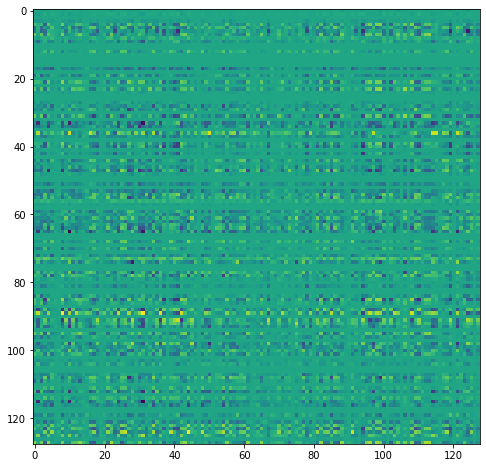

In [ ]:
import matplotlib.pyplot as plt


dataset = SampleLevelMTTDataset(LIST_OF_TAGS,AUDIO_DIR,NUM_TAGS,BASE_DIR)
samplecnn = SampleCNN()

dataset.annotation_file
dataset.annotations_frame

W1 = mysolver.w1
W2 = mysolver.w2
W3 = mysolver.w3
W4 = mysolver.w4

tri1  = W1[:,:,-1:].squeeze()
tri2  = W2[:,:,-3:-2].squeeze()
tri3  = W3[:,:,-1:].squeeze()
tri4  = W4[:,:,-1:].squeeze()


plt.figure(figsize = (8,8))
plt.imshow(tri2, interpolation='nearest',aspect='auto')

# retrieve weights from the second hidden layer
#filters.shape = [i for i in mysolver.samplecnn.children()][0][0].weight
#print(filters)
#filters = filters.cpu().detach().numpy()
#f_min, f_max = filters.min(), filters.max()
#filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
#n_filters, ix = 6, 1
#for i in range(n_filters):
    # get the filter
#    f = filters[i, :, :]
#    print("Filters of hidden Layers")
#    print(f)
    # plot each channel separately
#    for j in range(3):
#        # specify subplot and turn of axis
#        ax = plt.subplot(n_filters, 3, ix)
#        ax.set_xticks([])
#        ax.set_yticks([])
        # plot filter channel in grayscale
#        plt.imshow(f[:, j], cmap='gray')
#        ix += 1
# show the figure
#plt.show()


#l1 = [i for i in mysolver.samplecnn.children()][0]
#w1 = (l1[0].weight.squeeze().cpu().detach().numpy()).T
#l2 = [i for i in mysolver.samplecnn.children()][1]
#w2 = (l2[0].weight.squeeze().cpu().detach().numpy()).T
#l3 = [i for i in mysolver.samplecnn.children()][2]
#w3 = (l3[0].weight.squeeze().cpu().detach().numpy()).T
#l4 = [i for i in mysolver.samplecnn.children()][3]
#w4 = (l4[0].weight.squeeze().cpu().detach().numpy()).T

#plt.figure(figsize = (8,8))
#plt.imshow(w1, interpolation='nearest',aspect='auto')


# start training
print("Start training!!")
mysolver = Solver(samplecnn, dataset)
mysolver.train()
    
print("Finished! Hopefully..")

# test it
print("Start testing...")

In [ ]:
# load trained model
samplecnn = samplecnn.load_state_dict(torch.load('/content/gdrive/My Drive/ECE 5424 ML/homework_spring/Project/model/sampleCNN.pth'))

In [ ]:
# use model to predict
dataset = SampleLevelMTTDataset(LIST_OF_TAGS,AUDIO_DIR,NUM_TAGS,BASE_DIR)
dataloader = DataLoader(dataset, batch_size=dataset.annotations_frame.shape[0], shuffle=True, drop_last=False)
mysolver = Solver(samplecnn, dataset)

for i, data in enumerate(dataloader):
  audio = data['audio'].to(device)
  label = data['label'].to(device)

y_pred = mysolver.samplecnn(audio)

dataset mode:  train


AttributeError: ignored

Convert to PDF

In [ ]:
#Run below two lines (in google colab), installation steps to get .pdf of the notebook

#!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
#!pip install pypandoc

# (optional) After installation, comment above two lines and run again to remove installation comments from the notebook.

In [ ]:
# Find path to your notebook file in drive and enter in below line
!jupyter nbconvert --to latex "/content/gdrive/MyDrive/ECE 5424 ML/homework_spring/HW6/HW6_msalem.ipynb"